In [15]:
import ee
import geopandas as gpd
import fiona
import shapely
import contextily as cx
import json
from src.visualization import ee_viz
from src.data.ee import mtbs
from src.data import shape_processor
from src.data.ee import lcms_import
from src.data.ee import dynamic_world
import src.data.ee.ee_utils as ee_utils
import numpy as np
from src.data.ee import terrain
from src.data import gedi_pipeline
from src.data.ee import landsat_import
from src.constants import DATA_PATH, USER_PATH
from src.data import gedi_raster_matching
import rasterio as rio
from rasterio.plot import show

import importlib
importlib.reload(ee_viz)
importlib.reload(mtbs)
importlib.reload(terrain)
importlib.reload(lcms_import)
importlib.reload(landsat_import)
importlib.reload(landsat_import)
importlib.reload(ee_utils)
importlib.reload(gedi_raster_matching)

2023-10-24 15:24:51,003 DEBUG: Logger /home/jk871/fire-regen/src/data/ee/ee_utils.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-10-24 15:24:51,007 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.gedi_raster_matching' from '/home/jk871/fire-regen/src/data/gedi_raster_matching.py'>

In [3]:
ee.Authenticate()


Successfully saved authorization token.


In [4]:
ee.Initialize()

### Get Regions of interest

In [5]:
# Fetch simplified regions of interest - to avoid processing problems with really complicated shapes.
seki = gpd.read_file("../../data/shapefiles/seki_convex_hull.shp")
sierras = gpd.read_file("../../data/shapefiles/sierras_convex_hull.shp")

In [6]:
seki_complex = gpd.read_file("../../data/shapefiles/seki.shp")
seki_box = shape_processor.get_box(seki_complex)

In [6]:
sierras_complex = gpd.read_file("../../data/shapefiles/sierras.shp")
sierras_box = shape_processor.get_box(sierras_complex)

### Get Burn Severity Data

In [8]:
burn_severity_ic = mtbs.get_burn_severity_data().sort('system:time_start', False).filterDate('2021', '2022')

In [9]:
burn_severity_ic

In [10]:
ee_viz.viz_burn_severity(burn_severity_ic.first(), sierras.geometry.iloc[0], ['burn_severity', 'burn_year'])

Map(center=[38.81702351908157, -119.91791513913883], controls=(WidgetControl(options=['position', 'transparent…

### Get aggregated burn data - last burn severity for each pixel, and burn count for each pixel

In [11]:
burn_data = mtbs.get_aggregated_burn_data()
burn_data

In [12]:
ee_viz.viz_burn_severity(burn_data, seki.geometry.iloc[0], ['last_burn_severity', 'last_burn_year', 'burn_count'])

Map(center=[36.72976974493908, -118.62809181119908], controls=(WidgetControl(options=['position', 'transparent…

In [13]:
ee_viz.viz_burn_severity(burn_data, sierras.geometry.iloc[0], ['last_burn_severity'], ['Burn Severity'], landcover=False)

Map(center=[38.81702351908157, -119.91791513913883], controls=(WidgetControl(options=['position', 'transparent…

### Save Fire Raster as Geo Tiff

In [ ]:
ee_utils.save_image_to_drive(burn_data, polygon=seki_box.geometry[0], img_name='burn_data_seki', scale=30)

In [ ]:
ee_utils.save_image_to_drive(burn_data, polygon=sierras_box.geometry[0], img_name='burn_data_sierras', scale=30)

### Get Landsat 5

In [ ]:
for year in range(1994, 1999):
    ls5_img = landsat_import.get_landsat_5(sierras.geometry[0], str(year))
    ee_utils.save_image_to_drive(ls5_img, polygon=sierras.geometry[0], img_name=f'landsat5_{year}', scale=30, subfolder=f'/LANDSAT5/{year}')

In [ ]:
ls5_img = landsat_import.get_landsat_5(sierras.geometry[0], str(year))

In [ ]:
ls5_img

### Get Landsat 7

In [ ]:
for year in range(1999, 2013):
    ls5_img = landsat_import.get_landsat_7(sierras.geometry[0], str(year))
    ee_utils.save_image_to_drive(ls5_img, polygon=sierras.geometry[0], img_name=f'landsat7_{year}', scale=30, subfolder=f'/LANDSAT7/{year}')

In [ ]:
landsat_import.get_landsat_7(sierras.geometry[0], str(year))

### Get Landsat 8

In [ ]:
for year in range(2013, 2020):
    ls5_img = landsat_import.get_landsat_8(sierras.geometry[0], str(year))
    ee_utils.save_image_to_drive(ls5_img, polygon=sierras.geometry[0], img_name=f'landsat8_{year}', scale=30, subfolder=f'/LANDSAT8/{year}')

In [ ]:
for year in range(2020, 2023):
    ls5_img = landsat_import.get_landsat_8(sierras.geometry[0], str(year))
    ee_utils.save_image_to_drive(ls5_img, polygon=sierras.geometry[0], img_name=f'landsat8_{year}', scale=30, subfolder=f'/LANDSAT8/{year}')

In [ ]:
ls5_img = landsat_import.get_landsat_8(sierras.geometry[0], str(2019))

In [ ]:
# Sample a point
u_lon = -120.758501
u_lat = 38.096484
u_poi = ee.Geometry.Point(u_lon, u_lat)
print(ls5_img.sample(u_poi, 30).first().get('NDVI').getInfo())

0.45491625400591956


### Get Land Cover Raster from Dynamic World

In [18]:
dw_2018 = dynamic_world.get_land_cover('2018-01-01', '2019-01-01', sierras.geometry[0])
dw_2019 = dynamic_world.get_land_cover('2019-01-01', '2020-01-01', sierras.geometry[0])
dw_2020 = dynamic_world.get_land_cover('2020-01-01', '2021-01-01', sierras.geometry[0])
dw_2021 = dynamic_world.get_land_cover('2021-01-01', '2022-01-01', sierras.geometry[0])
dw_2022 = dynamic_world.get_land_cover('2022-01-01', '2023-01-01', sierras.geometry[0])

In [14]:
ee_utils.save_image_to_drive(dw_2018, polygon=sierras_box.geometry[0], img_name='dynamic_world_2018', scale=10)
ee_utils.save_image_to_drive(dw_2019, polygon=sierras_box.geometry[0], img_name='dynamic_world_2019', scale=10)
ee_utils.save_image_to_drive(dw_2020, polygon=sierras_box.geometry[0], img_name='dynamic_world_2020', scale=10)
ee_utils.save_image_to_drive(dw_2021, polygon=sierras_box.geometry[0], img_name='dynamic_world_2021', scale=10)
ee_utils.save_image_to_drive(dw_2022, polygon=sierras_box.geometry[0], img_name='dynamic_world_2022', scale=10)

### Get Terrain Data

In [ ]:
terrain_img = terrain.get_terrain_30m(sierras.geometry[0], 30)
terrain_img

Name,Description
elevation,Elevation


In [ ]:
import geemap
geemap.image_stats(terrain_img.clip(ee_utils.gdf_to_ee_polygon(sierras.geometry[0])), scale=30).getInfo()

{'max': {'aspect': 359.64776611328125,
  'elevation': 4412,
  'slope': 83.11160278320312,
  'soil': 19},
 'mean': {'aspect': 170.53700091434584,
  'elevation': 1489.7758375453318,
  'slope': 11.152174599004503,
  'soil': 8.219256819137978},
 'min': {'aspect': 0, 'elevation': -7, 'slope': 0, 'soil': 0},
 'std': {'aspect': 105.36707529136733,
  'elevation': 780.7755535241209,
  'slope': 9.773203225948782,
  'soil': 5.977674581832873},
 'sum': {'aspect': 35512631828.35004,
  'elevation': 310230979446.459,
  'slope': 2322329280.428951,
  'soil': 1711578365.7254896}}

In [ ]:
ee_utils.save_image_to_drive_per_band(terrain_img, polygon=sierras.geometry[0], img_name="terrain", scale=30)

### Get LCMS Data

In [ ]:
for year in range(1985, 1990):
    lcms = lcms_import.get_lcms_for_single_year(year, sierras.geometry[0])
    ee_utils.save_image_to_drive(lcms, polygon=sierras_box.geometry[0], img_name=f'lcms_{year}', scale=30)

In [ ]:
ee_viz.viz_burn_severity(lcms, sierras.geometry.iloc[0], ['land_cover'])

Map(center=[38.81702351908157, -119.91791513913883], controls=(WidgetControl(options=['position', 'transparent…

### Merge tif files

In [16]:
gedi_raster_matching.merge_dynamic_world_tiles_for_year(2019)

2023-10-24 15:25:13,175 DEBUG: Merging tiles for year 2019 [in merge_dynamic_world_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:133]
2023-10-24 15:25:13,179 DEBUG: Load tif tiles [in merge_raster_tiles at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:147]
2023-10-24 15:25:13,232 DEBUG: Merge rasters. [in merge_raster_tiles at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:153]
2023-10-24 15:25:28,747 DEBUG: Write output [in merge_raster_tiles at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:156]


In [23]:
gedi_raster_matching.merge_dynamic_world_tiles_for_year(2018)

2023-10-24 16:11:36,616 DEBUG: Merging tiles for year 2018 [in merge_dynamic_world_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:133]
2023-10-24 16:11:36,619 DEBUG: Load tif tiles [in merge_raster_tiles at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:147]
2023-10-24 16:11:36,649 DEBUG: Merge rasters. [in merge_raster_tiles at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:153]
2023-10-24 16:11:51,707 DEBUG: Write output [in merge_raster_tiles at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:156]


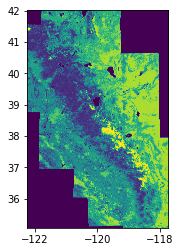

<AxesSubplot: >

In [17]:
year=2019
show(rio.open(f"{DATA_PATH}/rasters/DYNAMIC_WORLD/dynamic_world_{year}.tif"))

All the Rasters are downloaded from Earth Engine as tif files. We need to do two things:
1. For any rasters that have been downloaded as multiple files - merge them into a single raster.
2. Merge all rasters that represent single bands, into a single raster with multiple bands.

In [ ]:
for year in range(2020, 2023):
    gedi_raster_matching.merge_landsat_tiles_for_year(year)

2023-06-25 12:20:15,092 DEBUG: Merging tiles for year 2020 [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:124]
2023-06-25 12:20:15,096 DEBUG: Load tif tiles [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:135]
2023-06-25 12:20:15,161 DEBUG: Merge rasters. [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:141]
2023-06-25 12:22:25,310 DEBUG: Write output [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:144]
2023-06-25 12:23:32,744 DEBUG: Merging tiles for year 2021 [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:124]
2023-06-25 12:23:32,748 DEBUG: Load tif tiles [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:135]
2023-06-25 12:23:32,890 DEBUG: Merge rasters. [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi

In [ ]:
gedi_raster_matching.merge_landsat_tiles_for_year(2013)

2023-06-14 14:38:18,202 DEBUG: Merging tiles for year 2013 [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:132]
2023-06-14 14:38:18,207 DEBUG: Load tif tiles [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:143]
2023-06-14 14:38:18,231 DEBUG: Merge rasters. [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:149]
2023-06-14 14:40:28,142 DEBUG: Write output [in merge_landsat_tiles_for_year at /home/jk871/fire-regen/src/data/gedi_raster_matching.py:152]


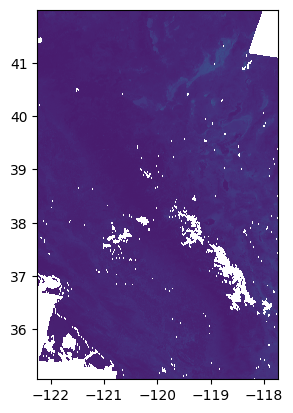

<Axes: >

In [ ]:
year=1984
show(rio.open(f"{DATA_PATH}/rasters/LANDSAT/{year}/landsat5_{year}.tif"))

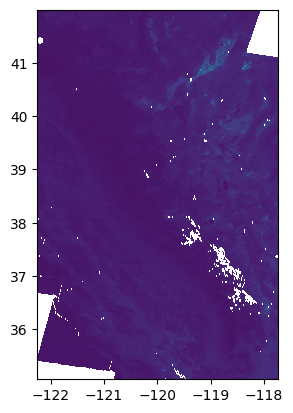

<Axes: >

In [ ]:
year=1990
show(rio.open(f"{DATA_PATH}/rasters/LANDSAT/{year}/landsat5_{year}.tif"))

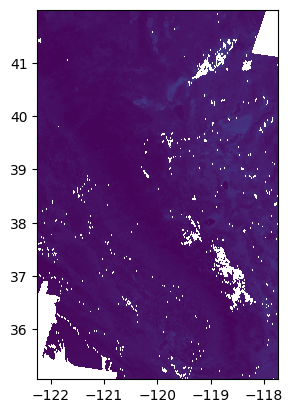

<Axes: >

In [ ]:
year=2012
show(rio.open(f"{DATA_PATH}/rasters/LANDSAT/{year}/landsat7_{year}.tif"))

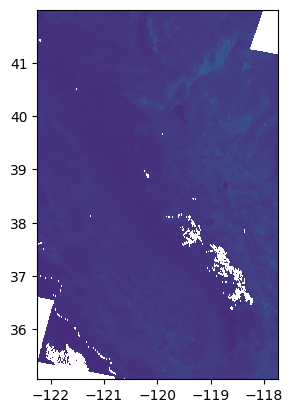

<Axes: >

In [ ]:
year=2013
show(rio.open(f"{DATA_PATH}/rasters/LANDSAT/{year}/landsat8_{year}.tif"))

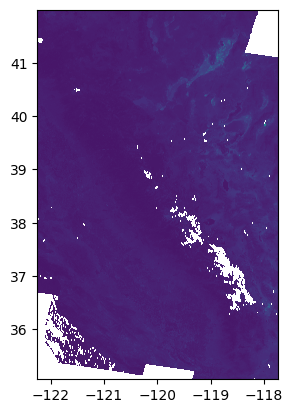

<Axes: >

In [ ]:
year=1986
show(rio.open(f"{DATA_PATH}/rasters/LANDSAT/{year}/landsat5_{year}.tif"))

### Combine multiple tifs into a single raster with multiple bands

In [ ]:
file_list = ['terrain_aspect.tif', 'terrain_elevation.tif', 'terrain_slope.tif', 'terrain_soil.tif']

# Read metadata of first file
with rio.open(f"{DATA_PATH}/rasters/TERRAIN_30/{file_list[0]}") as src0:
    meta = src0.meta

# Update meta to reflect the number of layers
meta.update(count = len(file_list))

# Read each layer and write it to stack
with rio.open(f"{DATA_PATH}/rasters/TERRAIN_30/terrain_stack.tif", 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rio.open(f"{DATA_PATH}/rasters/TERRAIN_30/{layer}") as src1:
            dst.write_band(id, src1.read(1))